In [100]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from io import BytesIO
import itertools
# Pillow library, to manipulate images
from PIL import Image
from os import walk

#https://towardsdatascience.com/image-processing-with-python-5b35320a4f3c
#https://github.com/TimChinenov/VaporWaveArt

In [101]:
# config
path = r"/Users/johann/PycharmProjects/PiQ/images_joh/edit/art"
N = 2
figSize = (40, 40)
dpi = 70

In [102]:
def rename_file(filename, foo):
    s = filename.split('.')
    return s[0]+foo+"."+'jpeg'

In [103]:
f = {}
f_upside = {}
filenames = walk(path)
shape = {}
index_map = {}
s = 1200
x, y = 0, 0
for _, _, filename in filenames: 
    for i, file in enumerate(filename):
        f[file] = np.array(Image.open(path+"/"+file))#[y:y+s, x:x+s]
        filename = rename_file(file, "_r")
        f[filename] = np.rot90(np.array(Image.open(path+"/"+file))[y:y+s, x:x+s], 2)

In [104]:
def reshape_split(image: np.ndarray, kernel_size: tuple):
#https://towardsdatascience.com/efficiently-splitting-an-image-into-tiles-in-python-using-numpy-d1bf0dd7b6f7
    img_height, img_width, channels = image.shape
    tile_height, tile_width = kernel_size

    tiled_array = image.reshape(img_height // tile_height, tile_height, img_width // tile_width, tile_width, channels)
    tiled_array = tiled_array.swapaxes(0, 2)
    return tiled_array

In [105]:
def normalize_to_range(x, endrange):
    """ 
    Function that normalizes an input array or matrix to a desired range 
    using a linear transformation.
    
    A system of two linear equations that map from one range (max-min) 
    to the desired range 
    
    y_min = a*x_min + b
    y_max = a*x_max + b
    
    Two equations with two unknowns. Analytical solutions for a and b are:
    
    a = (y_max - y_min) / (x_max - x_min)
    b = y_max - a*x_max
    
    """
    
    a = (endrange[1] - endrange[0]) / (x.max() - x.min())  
    b = endrange[1] - a*x.max()
    
    return a*x+b 

In [106]:
def join_dicts(a, b):
    out = {}
    while len(a) > 0 and len(b) > 0: 
        first = dict(itertools.islice(a.items(), 4))
        for key in first.keys():
            a.pop(key)
        second = dict(itertools.islice(b.items(), 4))
        for key in second.keys():
            b.pop(key)
        tmp = {**first , **second}
        out = {**out, **tmp}
    return out

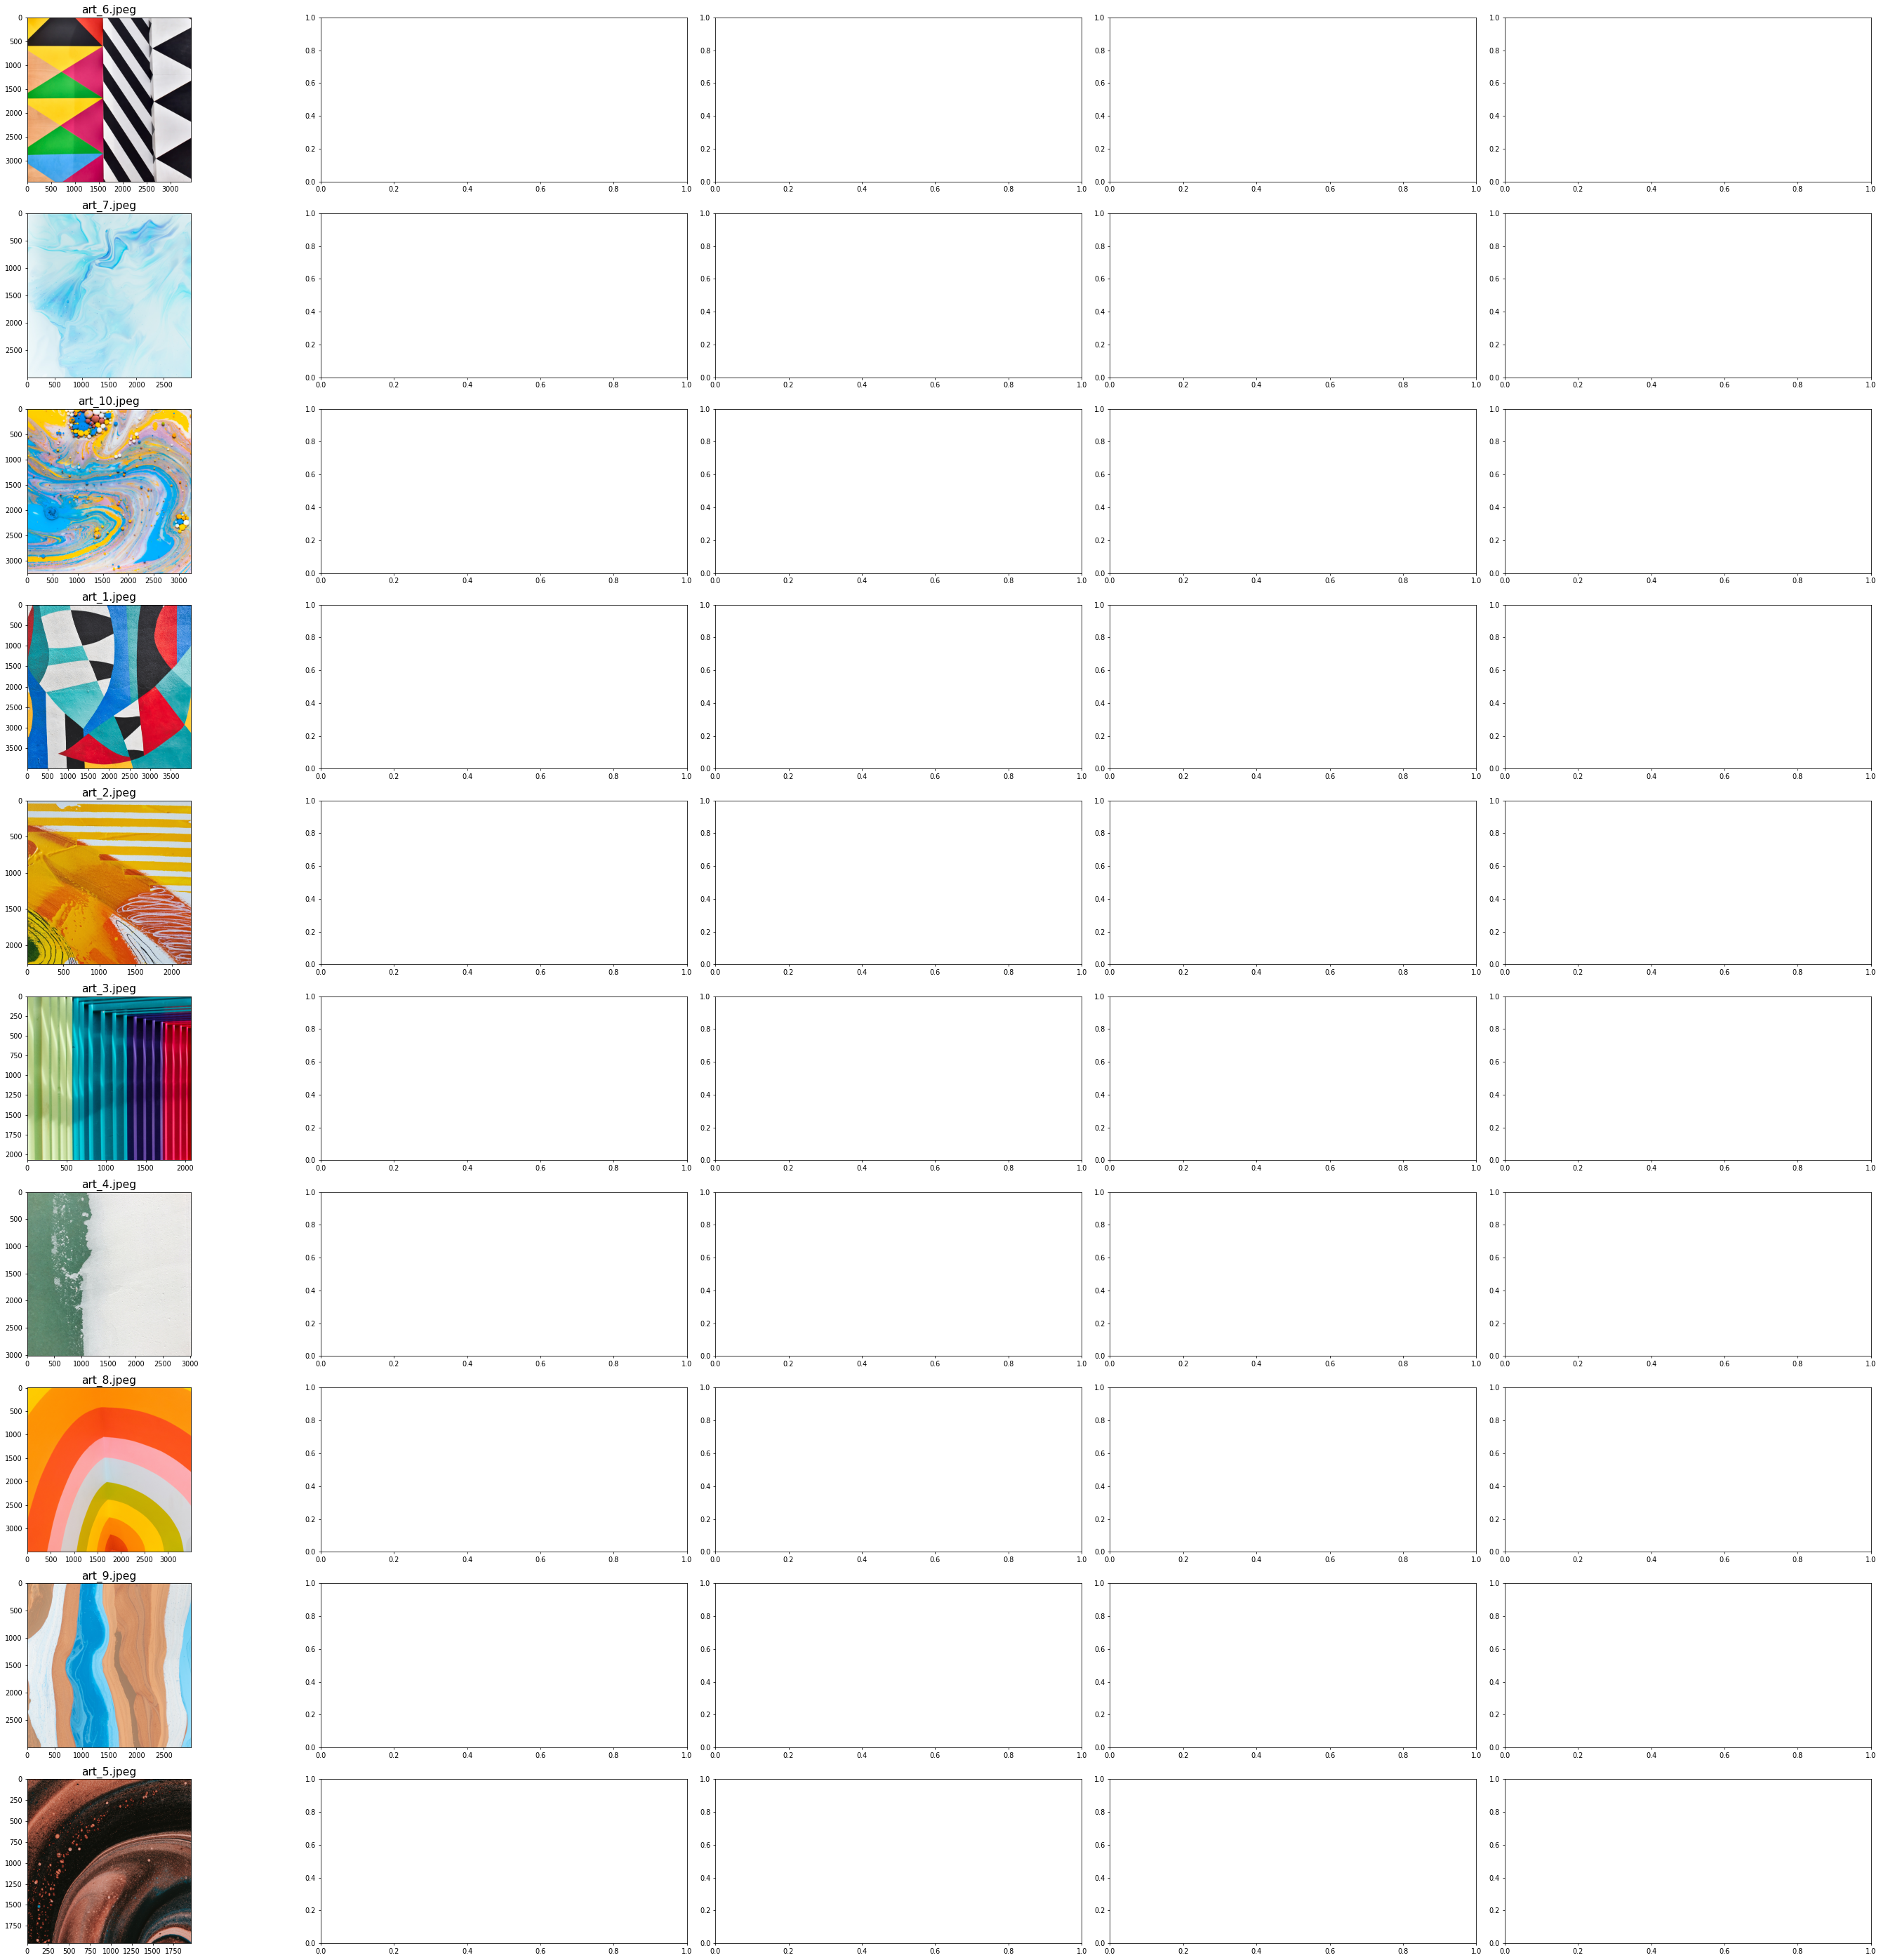

In [107]:
def plot_pictures(f):
    fig, axs = plt.subplots(10,5, figsize=figSize, dpi=dpi)
    for (key, row) in zip(f.keys(), axs.T.flatten()):
        row.imshow(f[key])
        row.set_title(key, fontsize=16)
    fig.tight_layout()
    
    
plot_pictures(f.copy())

In [ ]:
# noise
def generate_noise(f):
    f_noise = f.copy()
    pre = np.linspace(2, 8, 4)
    sigmas = np.round(np.exp(pre), 0).astype(np.int32)
    print(sigmas)
    shape = list(f_noise.values())[0].shape
    for i, sigma in enumerate(sigmas):
        noise = np.random.normal(loc=0, scale=sigma, size=shape)
        for file in f.keys():
            im = np.round(normalize_to_range(f_noise[file].copy()+noise, endrange = (0, 255)), 0).astype(np.int32)
            filename = rename_file(file, "_noise"+str(sigma))
            f_noise[filename] = im
    return f_noise

plot_pictures(generate_noise(f.copy()))

In [ ]:
# blur
def generate_blur(f):
    f_blur = f.copy()
    pre = np.linspace(1, 3, 4)
    sigmas = np.round(np.exp(pre), 0).astype(np.int32)
    print(sigmas)
    for i, sigma in enumerate(sigmas):
        for file in f.keys():
            im = f_blur[file].copy()
            im = ndimage.gaussian_filter(im, sigma=(sigma,sigma,0))
            filename = rename_file(file, "_blur"+str(sigma))
            f_blur[filename] = im
    return f_blur

plot_pictures(generate_blur(f.copy()))

In [ ]:
# salt and pepper
def generate_salt_pepper(f):
    f_sap = f.copy()
    pre = np.linspace(10, 15, 4)
    sigmas = np.round(np.exp(pre), 0).astype(np.int32)
    print(sigmas)
    n = list(f_sap.values())[0].shape[1]
    for i, sigma in enumerate(sigmas):
        spots_x = np.random.choice(range(n), sigma)
        spots_y = np.random.choice(range(n), sigma)
        for file in f.keys():
            im = f_sap[file].copy()
            for y in range(sigma):
                # we randomly assign either 0 (black) or 255 (white)
                im[spots_x[y], spots_y[y]] = np.random.randint(2)*255
            filename = rename_file(file, "_sap"+str(sigma))
            f_sap[filename] = im
    return f_sap



plot_pictures(generate_salt_pepper(f.copy()))

[20  7  3  1]


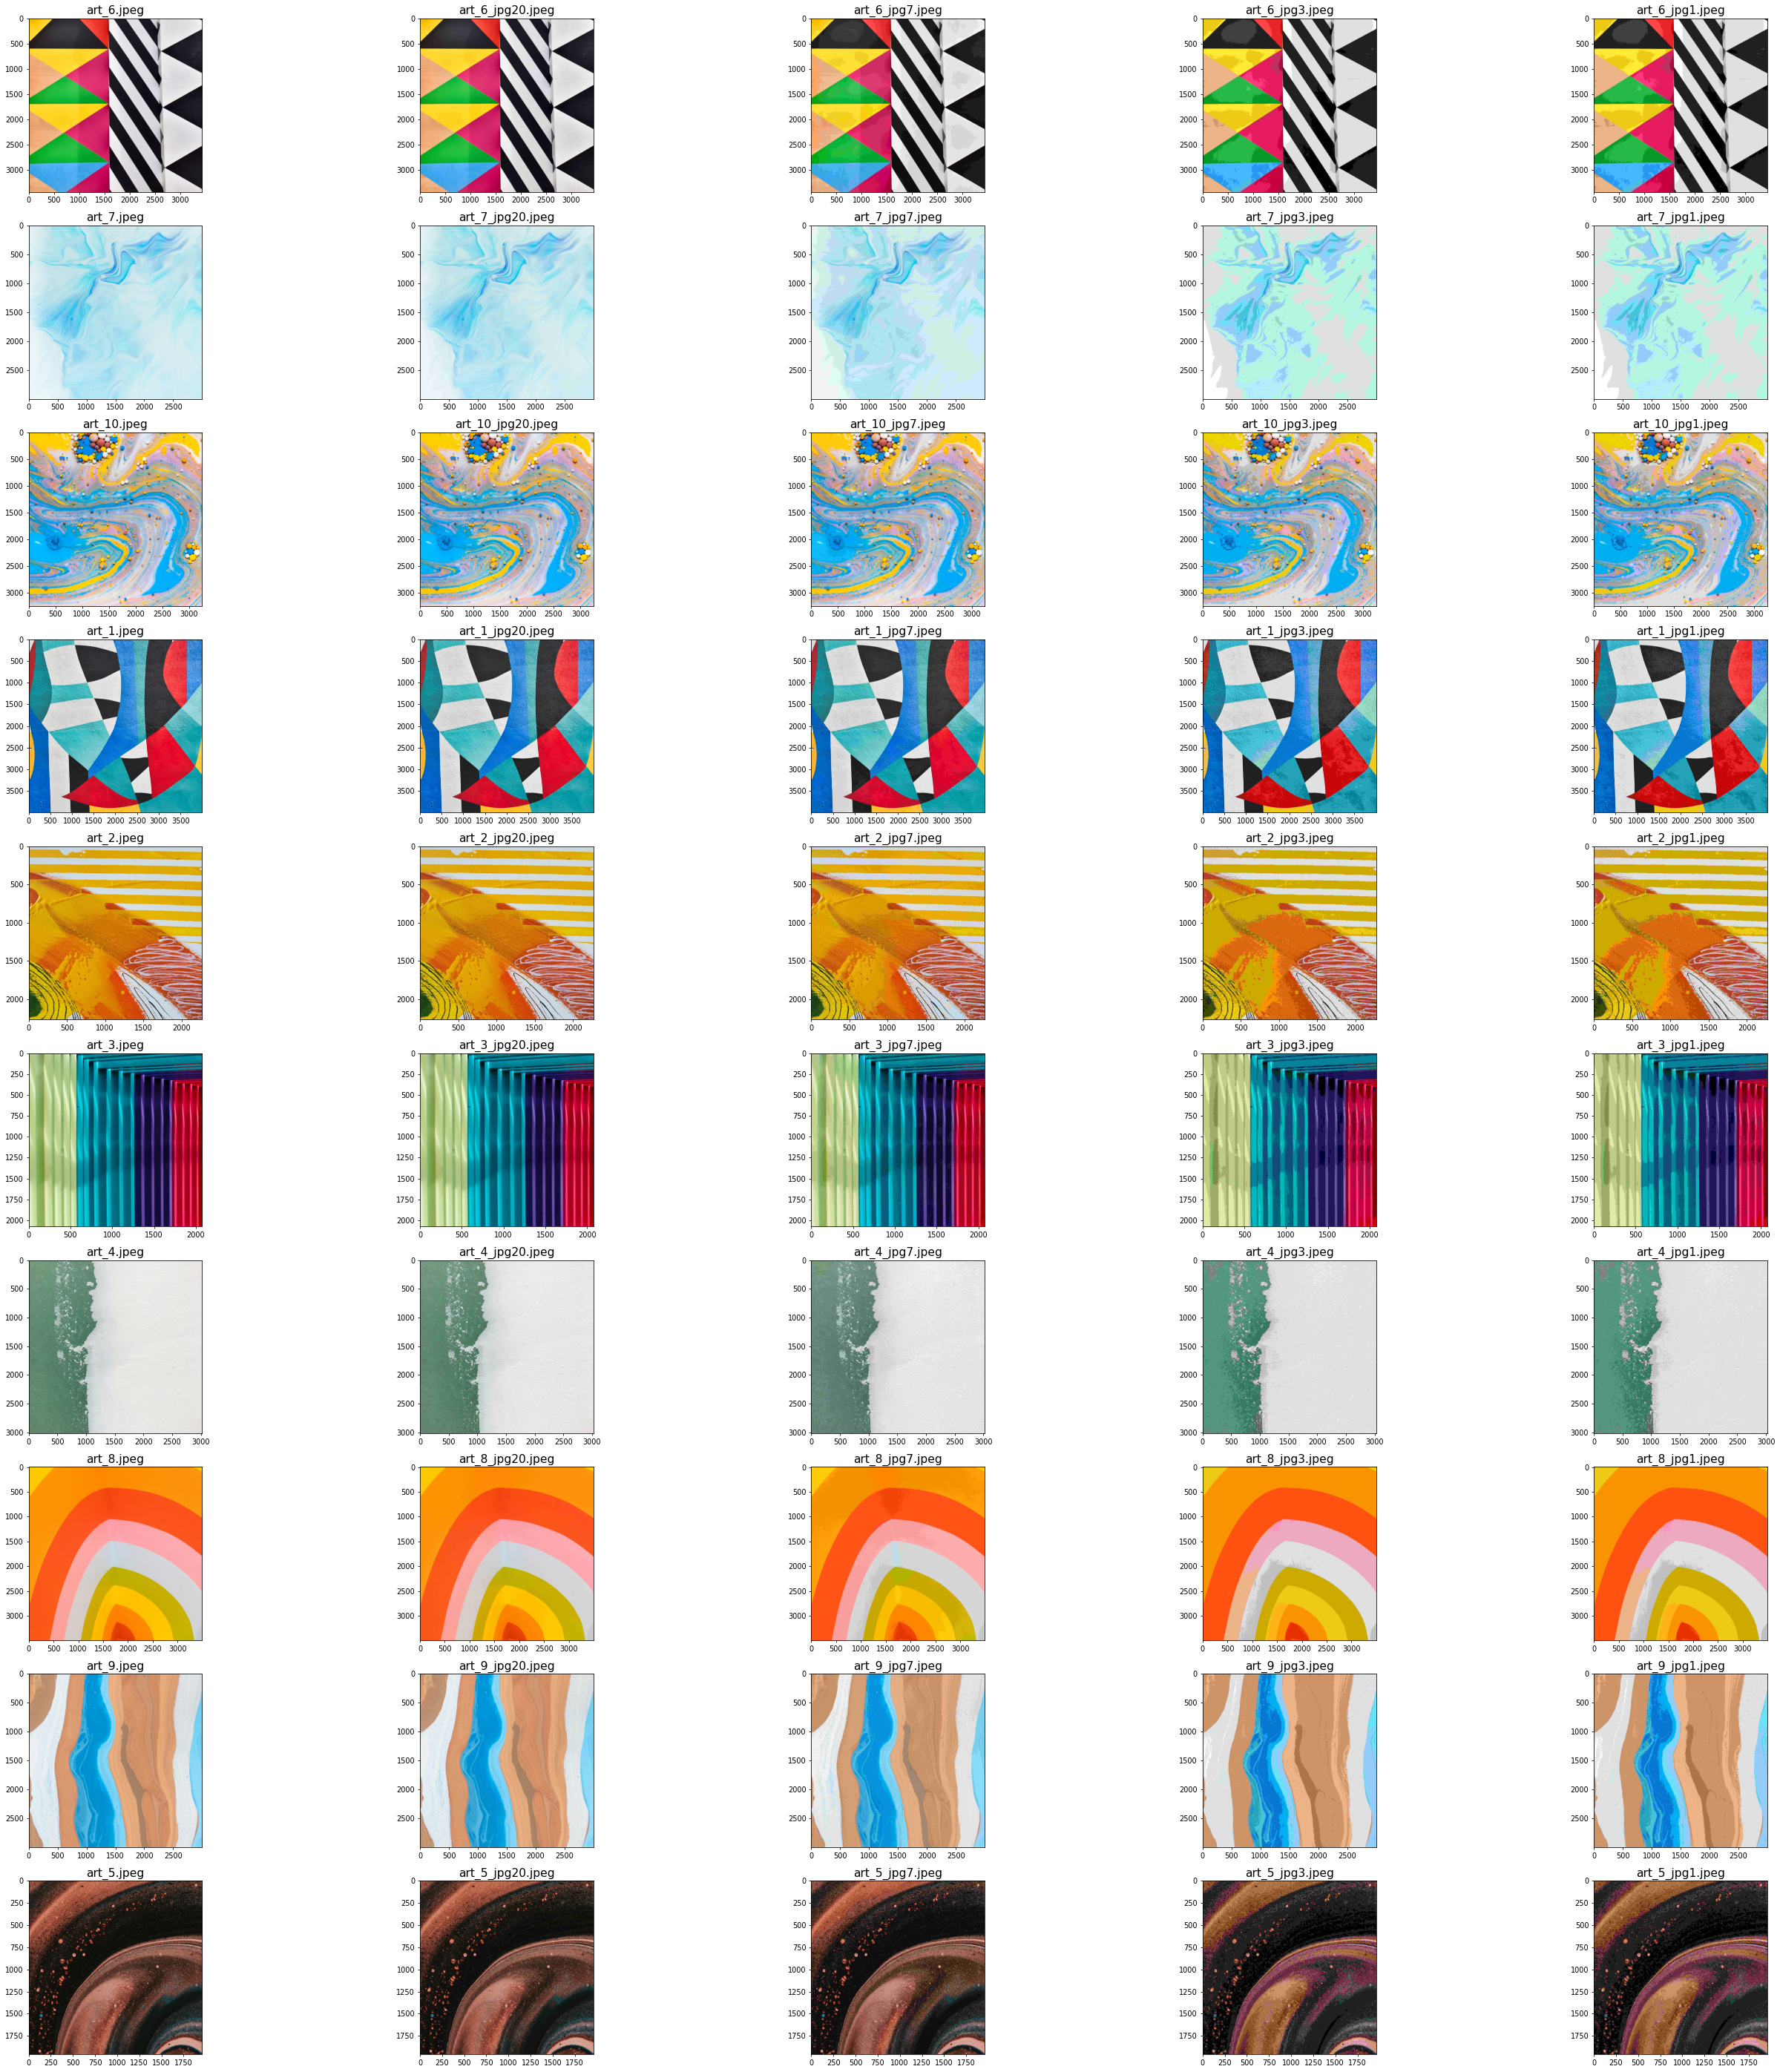

In [110]:
# jpg
def generate_jpg(f):
    f_jpg = f.copy()
    pre = np.linspace(0, 3, 4)
    sigmas = np.round(np.exp(pre), 0).astype(np.int32)[::-1]
    print(sigmas)
    for i, sigma in enumerate(sigmas):
        for file in f.keys():
            im = f[file].copy()
            buffer = BytesIO()
            Image.fromarray(im).save(buffer , 'jpeg', quality=int(sigma))
            im = Image.open(buffer)
            im = np.array(im)
            filename = rename_file(file, "_jpg"+str(sigma))
            f_jpg[filename] = im
    return f_jpg


plot_pictures(generate_jpg(f.copy()))

In [ ]:
# shuffle
def generate_shuffle(f):
    f_shuffle = f.copy()
    pre = np.linspace(0, 4, 4)
    sigmas = np.round(np.exp(pre), 0).astype(np.int32)[::-1]
    sigmas = [600, 300, 200, 100]
    print(sigmas)
    for i, sigma in enumerate(sigmas):
        chunkSize = (sigma, sigma)
        for file in f.keys():
            im = f[file].copy()
            im = reshape_split(im, chunkSize)
            np.random.shuffle(im)
            filename = rename_file(file, "_shuffle"+str(sigma))
            f_shuffle[filename] = im.reshape(f[file].shape)
    return f_shuffle


plot_pictures(generate_shuffle(f.copy()))